<h2><center><font color=#D40004><u>Augmented Generative Document Scraping</u></font></center></h2>



<div style="padding: 40px; background: linear-gradient(135deg, #f5f7fa, #cdd2d8); border: 3px groove #d1d8e0; border-radius: 30px; box-shadow: 0 10px 25px rgba(0,0,0,0.1); font-size: 120%; line-height: 1.9; color: #333; font-family: 'Georgia', serif; text-align: justify; position: relative;">
    <h2 style="color: #2c3e50; font-size: 150%; border-bottom: 3px solid #3498db; display: inline-block; padding-bottom: 10px; margin-bottom: 20px;">
        Project Objective
    </h2>
   <p style="font-size: 140%; color: #34495e; letter-spacing: 1px;">The main goal of this project is to utilize Large Language Models (LLMs) to extract specific information from PDF documents and organize it into a structured JSON format.</p>
<p>To achieve this objective, we are assessing various LLMs such as Mistral and Llama 2  to identify the most suitable model. Following this, we will fine-tune the selected model.</p>
<p>Our initial step involves converting the PDFs to text while preserving their structural integrity, allowing the LLMs to comprehend and extract information accurately. Subsequently, we will process each page individually, providing it as context to the model and requesting the extraction of information in JSON format.</p>
<p>In order to effectively compare these models, we will introduce appropriate metrics and implement them.</p>
</div>

# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:center; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'></span></b> <b>Table of Content</b></div>

* [I. Loading and Importing Libraries](#1)
* [II. Definition and Implementation of Metrics](#2)
* [III. Clean Response Obtained by LLM](#3)
* [IV. Converting PDF to Text Preserving Original Structure](#4)
* [V. Prepare Data for Benchmarking](#5)
* [VI. Benchmark](#6)
  * [Openchat-3.5-1210](#7)
  * [dolphin-2.2.1-mistral-7b](#8)
  

<a id='1'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>I |</span></b> <b>Loading and Importing Libraries</b></div>


In [ ]:
%%capture
!pip install --upgrade pip
!pip install bitsandbytes
!pip install transformers
!pip install pdfplumber

In [18]:
import re
import json
from tqdm import tqdm
import pandas as pd
from datasets import load_dataset, Dataset
import pdfplumber
from wand.image import Image as WImage
import torch
import time 
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

<a id='2'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>II |</span></b> <b>Definition and Implementation of Metrics</b></div>
So, let's begin by providing an example of the expected output.

In [20]:
desired_output = {
    "GeographicContext": "Intercountry",
    "SubGeographicContext": "Intra-Western",
    "Channel": "purchase at ATM",
    "RateType": "fallback fee rates",
    "Notes":["Maestro MO/TO is permitted only for refund transactions.",
"For transactions less than or equal to EUR 25 only. Transactions greater than EUR 25 are processed under normal Maestro acceptance criteria."],
    
    "Rates": [
        {
            "PaymentProduct": "Maestro Prepaid Commercial",
            "Details": [
                {
                    "FeeTier": "Chip",
                    "IRD": ["45"],
                    "Rate": "0.40% + EUR 0.05"
                },
                {
                    "FeeTier": "Chip: Late Presentment",
                    "IRD": ["45"],
                    "Rate": "0.75% + EUR 0.05"
                },
                {
                    "FeeTier": "PIN Verified",
                    "IRD": ["46"],
                    "Rate": "0.50% + EUR 0.05"
                },
                {
                    "FeeTier": "Signature Verified",
                    "IRD": ["47"],
                    "Rate": "0.75% + EUR 0.05"
                },
                {
                    "FeeTier": "Masterpass Wallet",
                    "IRD": ["PW"],
                    "Rate": "1.50%"
                },
                {
                    "FeeTier": "Secure E-commerce",
                    "IRD": ["48"],
                    "Rate": "1.05% + EUR 0.05"
                },
                {
                    "FeeTier": "Mail Order/Telephone Order",
                    "IRD": ["MO"],
                    "Rate": "1.05% + EUR 0.05"
                },
                {
                    "FeeTier": "Contactless",
                    "IRD": ["P1"],
                    "Rate": "0.40% + EUR 0.05"
                }
            ]
        },
        {
            "PaymentProduct": "Maestro",
            "Details": [
                {
                    "FeeTier": "Purchase part of the Purchase with Cash Back transaction",
                    "IRD": [],
                    "Rate": "Depending on tier claimed POS interchange rate relevant to the applicable tier. Refer to Intra-EEA Maestro POS Fallback Interchange Fee Rates."
                },
                {
                    "FeeTier": "Cash back part of the Purchase with Cash Back transaction",
                    "IRD": ["N/A"],
                    "Rate": "0.00"
                }
            ]
        }
    ]
}


To compare between the expected JSON and the predicted JSON, we first need to verify the percentage of predicted keys relative to the desired keys

>##  Percentage of predicted keys

Let's begin by defining a function to retrieve all keys from a dictionary.

In [21]:
def get_keys(d):
    # Iterate over each key-value pair in the dictionary
    for k, v in d.items():
        # Append the key to the list of all_keys
        all_keys.append(k)
        # If the value is a dictionary, recursively call get_keys
        if isinstance(v, dict):
            get_keys(v)
        # If the value is a list, iterate over each item
        elif isinstance(v, list):
            for item in v:
                # If the item is a dictionary, recursively call get_keys
                if isinstance(item, dict):
                    get_keys(item)
# Define a function to retrieve all unique keys from a nested dictionary
def get_all_keys(d):
    # Declare all_keys as a global variable
    global all_keys
    # Initialize all_keys as an empty list
    all_keys = []
    # Call the helper function get_keys to populate all_keys
    get_keys(d)
    # Return a list containing the unique keys by converting all_keys to a set and then back to a list
    return list(set(all_keys))

In [ ]:
# Testing our function
get_all_keys(desired_output)

Now, we define the percentage of predicted keys as follows:

$$\Large \text{Percentage of predicted keys} = \frac{\text{Number of correctly predicted keys}}{\text{Total number of true keys}}$$


In [4]:
def Percentage_of_predicted_keys(true_dic, pred_dic):
    # Get all keys of the true dictionary
    all_keys_of_true_dic = get_all_keys(true_dic)
    # Get all keys of the predicted dictionary
    all_keys_of_pred_dic = get_all_keys(pred_dic)
    
    # Check if there are no keys in the true dictionary to avoid division by zero
    if len(all_keys_of_true_dic) == 0:
        return 0  # Avoid division by zero
    
    # Initialize count of predicted keys
    p_keys = 0
    # Iterate through all keys in the predicted dictionary
    for key in all_keys_of_pred_dic:
        # Check if the key is also present in the true dictionary
        if key in all_keys_of_true_dic:
            # Increment count if the key is found in both dictionaries
            p_keys += 1
    
    # Calculate the percentage of predicted keys compared to true keys
    p_keys /= len(all_keys_of_true_dic)
    # Return the percentage of predicted keys
    return p_keys

In [5]:
# Define a true dictionary
true_dict = {
    "name": "John",
    "age": 30,
    "city": "New York"
}

# Define a predicted dictionary with some correct and some incorrect keys
pred_dict = {
    "name": "John",
    "age": 30,
    "country": "USA"
}

# Calculate the percentage of predicted keys
percentage = Percentage_of_predicted_keys(true_dict, pred_dict)

# Print the result
print("Percentage of predicted keys:", percentage)

Percentage of predicted keys: 0.6666666666666666


Now we will define the principal metrics used to compare the values of two JSON objects.

>## Percentage of predicted values

The function calculates the percentage of correctly predicted values compared to the total number of true values across different types of data structures.

The formula for calculating the percentage of values is as follows:

$$
\text{Percentage of values} = \frac{\sum_{i=1}^{\text{Total number of predicted keys}} p_i \cdot w_i}{\sum_{i=1}^{\text{Total number of true keys}} w_i}
$$

Here, $p_i$ represents the percentage of correctly predicted values for each key. It's calculated as:

$$p_i = \frac{\text{Number of correctly predicted values of item i}}{\text{Total number of true values of item i}}$$

and $ w_i$ is the total number of true values of item i.

In [6]:
# Define a function to count the values in a nested dictionary. This function assists in calculating weights.
def count_values_in_dic(d):
    # Initialize a counter
    count = 0
    
    # Check if d is a string
    if isinstance(d, (str,int,float)):
        # Increment the counter
        count += 1
        
    # Check if d is a list containing only strings
    if isinstance(d, list) and all(isinstance(item, (str,int,float)) for item in d):
        # Add the length of the list to the counter
        count += len(d)
        
    # Check if d is a list containing only dictionaries
    if isinstance(d, list) and all(isinstance(item, dict) for item in d):
        # Iterate through each item in the list
        for item in d:
            # Recursively call count_values_in_dic for each item in the list
            count += count_values_in_dic(item)
  
    # Check if d is a dictionary
    if isinstance(d, dict):
        # Traverse through the dictionary items
        for key, value in d.items():
            # If the value is a string, increment the counter
            if isinstance(value, (str,int,float)):
                count += 1
            
            # If the value is a dictionary, count its values recursively
            elif isinstance(value, dict):
                count += count_values_in_dic(value)
                    
            # If the value is a list, count the values in the list      
            elif isinstance(value, list):
                # Iterate through each element in the list
                for item in value:
                    # If the element is a dictionary, count its values
                    if isinstance(item, dict):
                        count += count_values_in_dic(item)
                    # If the element is a string, increment the counter
                    elif isinstance(item, (str,int,float)):
                        count += 1

    # Return the total count
    return count

In [7]:
# Define a sample nested dictionary
sample_dict = {
    "name": "John",
    "age": 30,
    "city": "New York",
    "friends": [
        {
            "name": "Alice",
            "age": 28
        },
        {
            "name": "Bob",
            "age": 32
        }
    ],
    "hobbies": ["reading", "traveling", "cooking"]
}

# Count the values in the dictionary
values_count = count_values_in_dic(sample_dict)

# Print the result
print("Number of values in the dictionary:", values_count)

Number of values in the dictionary: 10


In [8]:
def calculate_percentage_of_values(true_dic, pred_dic):
    total_percentage = 0  # Initialize total percentage
    sum_of_w_i = 0 # Initialize sum of weights
    
    # Type 1: Single string values
    for key, true_value in true_dic.items():  # Loop through key-value pairs in true_dic
        if isinstance(true_value, str):  # Check if the value is a string
            w_i = 1 # Weight for this item
            sum_of_w_i += w_i  # Add weight to the sum of weights
            # Check if the key exists in pred_dic, if its value is a string and if it matches the true value
            if key in pred_dic and isinstance(pred_dic[key], str) and pred_dic[key] == true_value:
                match = 1  # Assign perfect match
            else:
                match = 0  # Assign no match
            total_percentage += match*w_i  # Add the match value to the total percentage
            
    # Type 2: Lists of strings
    for key, true_value in true_dic.items():  # Loop through key-value pairs in true_dic
        if isinstance(true_value, list) and all(isinstance(item, str) for item in true_value):
            # Check if the value is a list of strings
            w_i = len(true_value) # Weight for this item
            sum_of_w_i += w_i  # Add weight to the sum of weights
            total_number_of_true_values = len(true_value)  # Get the total number of true values
            
            if key in pred_dic and isinstance(pred_dic[key], list):
                # Check if the key exists in pred_dic and its value is a list
                correct_pred_values = sum(1 for v in pred_dic[key] if v in true_value)  # Count correct predictions
            else:
                correct_pred_values = 0  # No correct predictions if the key doesn't exist or its value is not a list
            if total_number_of_true_values:
                percentage_correct = correct_pred_values / total_number_of_true_values  # Calculate percentage of correct predictions
            else:
                percentage_correct = 0  # If there are no true values, assign 0
            total_percentage += percentage_correct*w_i  # Add the percentage to the total percentage
    
    # Type 4: dictionarie
    for key, true_value in true_dic.items():  # Loop through key-value pairs in true_dic
        if isinstance(true_value, dict)  :
            w_i = count_values_in_dic(true_value) # Weight for this item
            sum_of_w_i += w_i # Add weight to the sum of weights
            
            if key in pred_dic and isinstance(pred_dic[key], dict):
                percentage_correct = calculate_percentage_of_values(true_value, pred_dic[key])
            else:
                percentage_correct = 0
            total_percentage += percentage_correct*w_i
    # Type 5: Lists of dictionaries
    for key, true_value in true_dic.items():  # Loop through key-value pairs in true_dic
        if isinstance(true_value, list) and all(isinstance(item, dict) for item in true_value):
            # Check if the value is a list of dictionaries
            w_i = count_values_in_dic(true_value) # Weight for this item
            sum_of_w_i += w_i # Add weight to the sum of weights
            sub_total_percentage = 0  # Initialize subtotal percentage
            
            for dict_item in true_value:  # Loop through each dictionary in the list
                max_similarity = 0  # Initialize max similarity score
                most_similar_pred_item = None  # Initialize most similar predicted item
                pred_items = pred_dic.get(key, [])  # Get predicted items for the current key
                #print(dict_item)
                for pred_item in pred_items:  # Loop through each prediction for the current key
                    
                    similarity = calculate_percentage_of_values(dict_item, pred_item)  # Calculate similarity

                    if similarity > max_similarity:
                        max_similarity = similarity
                        most_similar_pred_item = pred_item
                    if max_similarity==1:
                        break
                if most_similar_pred_item is not None:
                    pred_items.remove(most_similar_pred_item)  # Remove the most similar predicted item from the list
                sub_total_percentage += max_similarity  # Add max similarity to subtotal
                
            if len(true_value) > 0:
                average_similarity = sub_total_percentage / len(true_value)  # Calculate average similarity
            else:
                average_similarity = 0  # If there are no dictionaries, assign 0
            total_percentage += average_similarity* w_i  # Add the percentage to the total percentage
    #print(total_percentage , sum_of_w_i)
    return total_percentage / sum_of_w_i  # Calculate and return the average percentage

In [9]:
true_dict = {
    'a': 'hello',
    'b': ['world', 'foo', 'bar'],
    'c': [{'x': 'apple'}, {'y': 'banana'}, {'z': 'orange'}],
    'd': {
        'e': 'python',
        'f': ['java', 'javascript'],
        'g': [{'h': 'ruby'}, {'i': 'php'}]
    }
}

pred_dict = {
    'a': 'Hey',
    'b': ['world', 'foo', 'bar'],
    'c': [{'x': 'apple'}, {'y': 'banana'}, {'z': 'orange'}],
    'd': {
        'e': 'python',
        'f': ['java', 'javascript'],
        'g': [{'h': 'ruby'}, {'i': 'php'}]
    }
}

# Calculate the percentage of predicted values
percentage = calculate_percentage_of_values(true_dict, pred_dict)

# Print the result
print("Percentage of predicted values:", percentage)

Percentage of predicted values: 0.9166666666666666


<a id='3'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>III |</span></b> <b>Clean Response Obtained by LLM</b></div>

Our goal is to obtain a response from LLM in JSON format. However, LLMs sometimes provide additional explanatory sentences along with the JSON data. Therefore, we need to define a function to extract only the JSON data from the response.

Here example of our issue:
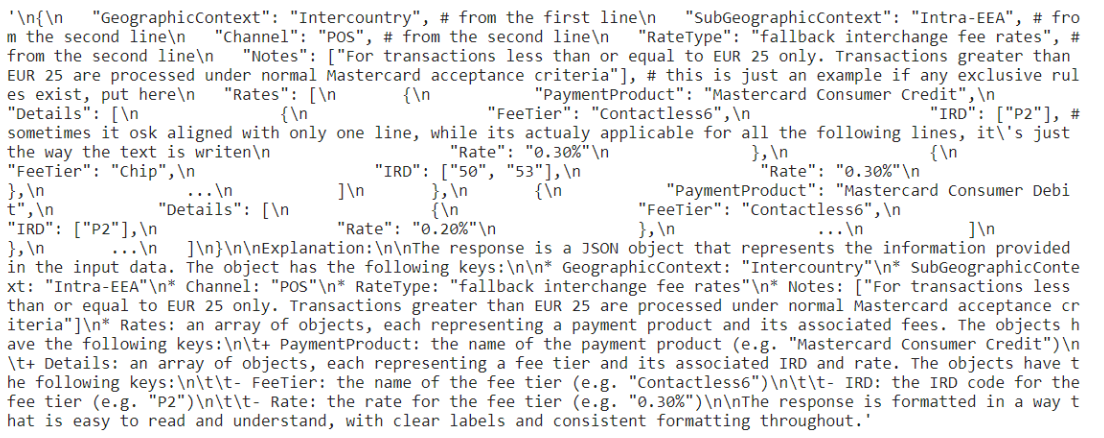

In [10]:
def clean_and_load_json(s):
    # Remove comments
    s = re.sub(r'//.*?\n', '', s)
    s = re.sub(r'#.*?\n', '', s) 
    # Remove trailing commas before closing brackets in lists and dictionaries
    s = re.sub(r',\s*\n\s*(\]|\})', r'\1', s)
    # Remove patterns like '\n       ...\n'
    s = re.sub(r'\n\s*\.\.\.\n', '', s)
    # Remove comma before } or ]
    s = re.sub(r',\s*(\]|\})', r'\1', s)
    # Remove unnecessary whitespace
    s = s.strip()
    # Load the cleaned JSON string
    print(s)
    return json.loads(s)

In [11]:
def parse_json(s):
    s = s.replace('{"message": "Context lacks a Payment product,FeeTier and Rate"}','')
    if '{' in s:    
        try:
            json_str = json.loads(s)
        except:
            # Find the index of the first occurrence of '{\n'
            start_idx = s.find('{')

            # Find the index of the last occurrence of '\n}'
            end_idx = s.rfind('}')

            # If either index is not found, raise an error
            if start_idx == -1 or end_idx == -1:
                return {"message": "Context lacks a Payment product,FeeTier and Rate"}

            # Extract the JSON substring from start_idx to end_idx (inclusive) + 3 to include the closing '\n}'
            json_str = s[start_idx:end_idx+1]
            try:
                 json_str = json.loads(json_str)
            except:
                json_str =  clean_and_load_json(json_str)
    else:
        return {"message": "Context lacks a Payment product,FeeTier and Rate"}
    return json_str

In [22]:
# test our function in last example 
st = '\n{\n   "GeographicContext": "Intercountry", # from the first line\n   "SubGeographicContext": "Intra-EEA", # from the second line\n   "Channel": "POS", # from the second line\n   "RateType": "fallback interchange fee rates", # from the second line\n   "Notes": ["For transactions less than or equal to EUR 25 only. Transactions greater than EUR 25 are processed under normal Mastercard acceptance criteria"], # this is just an example if any exclusive rules exist, put here\n   "Rates": [\n       {\n           "PaymentProduct": "Mastercard Consumer Credit",\n           "Details": [\n               {\n                   "FeeTier": "Contactless6",\n                   "IRD": ["P2"], # sometimes it osk aligned with only one line, while its actualy applicable for all the following lines, it\'s just the way the text is writen\n                   "Rate": "0.30%"\n               },\n               {\n                   "FeeTier": "Chip",\n                   "IRD": ["50", "53"],\n                   "Rate": "0.30%"\n               },]\n       },\n       {\n           "PaymentProduct": "Mastercard Consumer Debit",\n           "Details": [\n               {\n                   "FeeTier": "Contactless6",\n                   "IRD": ["P2"],\n                   "Rate": "0.20%"\n               },\n               ...\n   ]\n       },\n       ...\n   ]\n}\n\nExplanation:\n\nThe response is a JSON object that represents the information provided in the input data. The object has the following keys:\n\n* GeographicContext: "Intercountry"\n* SubGeographicContext: "Intra-EEA"\n* Channel: "POS"\n* RateType: "fallback interchange fee rates"\n* Notes: ["For transactions less than or equal to EUR 25 only. Transactions greater than EUR 25 are processed under normal Mastercard acceptance criteria"]\n* Rates: an array of objects, each representing a payment product and its associated fees. The objects have the following keys:\n\t+ PaymentProduct: the name of the payment product (e.g. "Mastercard Consumer Credit")\n\t+ Details: an array of objects, each representing a fee tier and its associated IRD and rate. The objects have the following keys:\n\t\t- FeeTier: the name of the fee tier (e.g. "Contactless6")\n\t\t- IRD: the IRD code for the fee tier (e.g. "P2")\n\t\t- Rate: the rate for the fee tier (e.g. "0.30%")\n\nThe response is formatted in a way that is easy to read and understand, with clear labels and consistent formatting throughout.'

# Extract JSON
parsed_json = parse_json(st)

# Print the result
parsed_json

{
   "GeographicContext": "Intercountry",    "SubGeographicContext": "Intra-EEA",    "Channel": "POS",    "RateType": "fallback interchange fee rates",    "Notes": ["For transactions less than or equal to EUR 25 only. Transactions greater than EUR 25 are processed under normal Mastercard acceptance criteria"],    "Rates": [
       {
           "PaymentProduct": "Mastercard Consumer Credit",
           "Details": [
               {
                   "FeeTier": "Contactless6",
                   "IRD": ["P2"],                    "Rate": "0.30%"
               },
               {
                   "FeeTier": "Chip",
                   "IRD": ["50", "53"],
                   "Rate": "0.30%"
               }]
       },
       {
           "PaymentProduct": "Mastercard Consumer Debit",
           "Details": [
               {
                   "FeeTier": "Contactless6",
                   "IRD": ["P2"],
                   "Rate": "0.20%"
               }]
       }]
}


{'GeographicContext': 'Intercountry',
 'SubGeographicContext': 'Intra-EEA',
 'Channel': 'POS',
 'RateType': 'fallback interchange fee rates',
 'Notes': ['For transactions less than or equal to EUR 25 only. Transactions greater than EUR 25 are processed under normal Mastercard acceptance criteria'],
 'Rates': [{'PaymentProduct': 'Mastercard Consumer Credit',
   'Details': [{'FeeTier': 'Contactless6', 'IRD': ['P2'], 'Rate': '0.30%'},
    {'FeeTier': 'Chip', 'IRD': ['50', '53'], 'Rate': '0.30%'}]},
  {'PaymentProduct': 'Mastercard Consumer Debit',
   'Details': [{'FeeTier': 'Contactless6', 'IRD': ['P2'], 'Rate': '0.20%'}]}]}

<a id='4'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>IV |</span></b> <b>Converting PDF to Text Preserving Original Structure</b></div>

In [23]:
def extract_text_from_pdf(pdf_path):
    docs=[]
    with pdfplumber.open(pdf_path) as pdf:
        for page_number, page in enumerate(pdf.pages, start=1):
            # Try to extract the text
            text= page.extract_text(x_tolerance=2, y_tolerance=4, layout=True, x_density=5, y_density=10)
            docs.append({'page_num':page_number, 'text':text})
           
    return docs

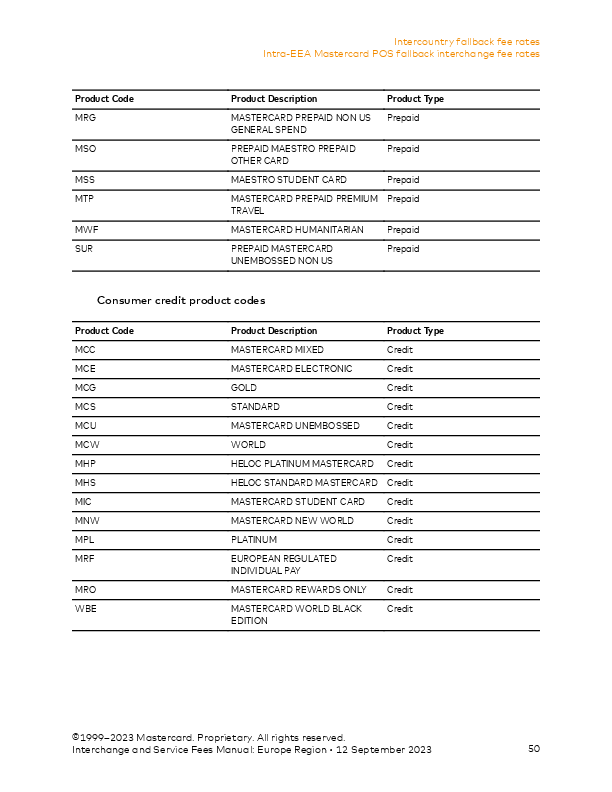

In [24]:
# Display the first page of our PDF
path = '/kaggle/input/somepages/mc_EuropeInterchangeManual_Customer-50-52.pdf'
img = WImage(filename=path)
img

In [25]:
# Convert PDF to text
docs = extract_text_from_pdf(path)

# Print the text of the first page to compare the structure between the converted and original
print(docs[0]['text'])

                                                                                                                          
                                                                                                                          
                                                                                                                          
                                                                                                                          
                                                                               Intercountry fallback fee rates            
                                                     Intra-EEA Mastercard POS  fallback interchange fee rates             
                                                                                                                          
                                                                                                                          
                

<a id='5'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>V |</span></b> <b>Prepare Data for Benchmarking</b></div>
<p>To benchmark LLms, we require a dataset comprising context and correct responses. To create this dataset, we have extracted 59 pages from our PDF and provided them to Gemini. We have requested Gemini to provide responses in JSON format. Subsequently, we have verified the results obtained from Gemini.</p>


In [26]:
with open("/kaggle/input/mc-eurpen/mc_EuropeInterchangeManual_Customer (2).txt", 'r', encoding='utf-8') as file:
    content = file.read()

token = 'Interchange and  Service Fees Manual: Europe Region • 12 September  2023'
paginated_doc = content.split(token)

In [27]:
data = []
i=40
with open("/kaggle/input/clean-data-for-fine-t/clean_data.jsonl",encoding='utf-8') as file:
    for line in file:
        response = json.loads(line)
        context = paginated_doc[i]
        data.append({"context":context,"response":response})
        i+=1

In [28]:
df = pd.DataFrame(data)
df.shape

(59, 2)

In [29]:
print(df.loc[0,'context'])

                    41              
                                                                                                                          
                                                                                                                                                                                                                                                    
                                                                                                                          
                                                                                                                          
                                                                                                                          
                                                                                       Global program  rates              
                                                                                                       

In [30]:
print(df.loc[0,'response'])

{'message': 'Context lacks a Payment product,FeeTier and Rate'}


In [31]:
print(df.loc[15,'context'])

                    56              
                                                                                                                          
                                                                                                                                                                                                                                                    
                                                                                                                          
                                                                                                                          
                                                                                                                          
                                                                               Intercountry fallback fee rates            
                               Intra-EEA Mastercard  MoneySend   funding transaction fallback service f

In [32]:
print(df.loc[15,'response'])

{'GeographicContext': 'Intercountry', 'SubGeographicContext': 'Intra-EEA', 'Channel': 'Mastercard MoneySend funding transaction', 'RateType': 'fallback service fee rates', 'Notes': [], 'Rates': [{'PaymentProduct': 'Mastercard BusinessCard/Mastercard Professional Card/Mastercard Executive BusinessCard/Mastercard Corporate Executive Card\nMastercard Electronic BusinessCard\nDebit Mastercard for Business', 'Details': [{'FeeTier': 'N/A', 'IRD': ['Q6', 'Q7'], 'Rate': '1.65%'}]}, {'PaymentProduct': 'Mastercard Purchasing', 'Details': [{'FeeTier': 'N/A', 'IRD': ['Q6', 'Q7'], 'Rate': '1.65%'}]}, {'PaymentProduct': 'Mastercard Fleetcard', 'Details': [{'FeeTier': 'N/A', 'IRD': ['Q6', 'Q7'], 'Rate': '1.65%'}]}, {'PaymentProduct': 'Mastercard Prepaid\nCommercial', 'Details': [{'FeeTier': 'N/A', 'IRD': ['Q6', 'Q7'], 'Rate': '1.65%'}]}]}


<a id='6'></a>
# <div style="padding: 30px; color:white; margin:10; font-size:75%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>VI |</span></b> <b>Benchmark</b></div>


In [30]:
 prompt = """
Please fill in the provided information from INPUTDATA to match the format below. Any elements prefixed by <var> are variables used for explanatory purposes. If a value is not found, please leave it empty. Note that the data in this template are for reference only; do not use them. If a value is not found, leave it empty.
{
    "GeographicContext": <var>"Intercountry", # from the first line
    "SubGeographicContext": <var>"Intra-EEA", # from the second line
    "Channel": <var>"Mastercard POS", # from the second line
    "RateType": <var>"fallback interchange fee rates", # from the second line
	"Notes": <var>["For transactions less than or equal to EUR 25 only. Transactions greater than EUR 25 are processed under normal Mastercard acceptance criteria"], # this is just an example if any exlusive rules existe, put here
    "Rates": [
        {
            "PaymentProduct": <var>"Mastercard Consumer Credit",
            "Details": [
                {
                    "FeeTier": <var>"Contactless6",
                    "IRD": <var>["P2"], # sometimes it oosk aligned with only one line, while its actualy applicable for all the folloing lines, it's just the way the text is writen
                    "Rate": <var>"0.30%"
                },
                {
                    "FeeTier": <var>"Chip",
                    "IRD": <var>["50", "53"],
                    "Rate": <var>"0.30%"
                },
                ...
            ]
        },
        {
            "PaymentProduct": <var>"Mastercard Consumer Debit",
            "Details": [
                {
                    "FeeTier": <var>"Contactless 6",
                    "IRD": <var>["P2"],
                    "Rate": <var>"0.20%"
                },
                ...
            ]
        },
        ...
    ]
}

If the INPUTDATA is missing a Payment product, respond with the following JSON:
{"message": "Context lacks a Payment product,FeeTier and Rate"}

"""

In [31]:
def accuracy(df):
    df['clean_pred_response'] = df['pred_response'].map(parse_json)
    
    average_percentage_of_predicted_keys = 0
    average_percentage_of_predicted_values = 0
    
    for i in df.index:
        true_dic = df.loc[i,'response']
        pred_dic = df.loc[i,'clean_pred_response']
        average_percentage_of_predicted_keys += Percentage_of_predicted_keys(true_dic, pred_dic)
        average_percentage_of_predicted_values += calculate_percentage_of_values(true_dic, pred_dic)

    average_percentage_of_predicted_keys /= df.shape[0]
    average_percentage_of_predicted_values /= df.shape[0]
    
    return average_percentage_of_predicted_keys,average_percentage_of_predicted_values

<a id='7'></a>
>## Openchat-3.5-1210

In [34]:
base_model_id = "openchat/openchat-3.5-1210"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(base_model_id)

config.json:   0%|          | 0.00/623 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [38]:
# Create a copy of the DataFrame
df_copy = df.copy()
df_copy['pred_response'] = None

# Iterate through each row in the DataFrame with tqdm for progress visualization
for i in tqdm(df_copy.index, desc="Generating Predictions", total=len(df_copy)):
    
    template = f"Instruction:\n{prompt}\nINPUTDATA:{df_copy.loc[i,'context']}\nResponse:\n"
    model_input = tokenizer(template, return_tensors="pt")
    pred_reponse = tokenizer.decode(model.generate(**model_input, max_new_tokens=1500,temperature=0.001,top_p=0.95, repetition_penalty=1.15)[0], skip_special_tokens=True)
    # Update the 'pred_response' column with the generated prediction
    df_copy.loc[i,'pred_response'] = pred_reponse.replace(template,'')

Generating Predictions:   0%|          | 0/59 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.001` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1477: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure

In [64]:
average_percentage_of_predicted_keys, average_percentage_of_predicted_values = accuracy(df_copy)
print("Average Percentage of Predicted Keys:", average_percentage_of_predicted_keys)
print("Average Percentage of Predicted values:", average_percentage_of_predicted_values)

Average Percentage of Predicted Keys: 0.423728813559322
Average Percentage of Predicted values: 0.19475546210537203


In [38]:
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": template}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to('cuda')

generated_ids = model.generate(
    model_inputs.input_ids,
    max_new_tokens=2000
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
2024-03-19 10:49:14.622648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 10:49:14.622797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 10:49:14.777267: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<a id='8'></a>
>## dolphin-2.2.1-mistral-7b

In [41]:
base_model_id = "cognitivecomputations/dolphin-2.2.1-mistral-7b"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto",trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(base_model_id, use_fast=False,device_map="auto")

config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.70k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [42]:
template = f"Instruction:\n{prompt}\nINPUTDATA:{df.loc[12,'context']}\nResponse:\n"

In [47]:
# conversation = [ {'role': 'user', 'content': template} ] 

# prompt1 = tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)

inputs = tokenizer(template, return_tensors="pt").to(model.device) 
outputs = model.generate(**inputs, use_cache=True,max_length=4096)
output_text = tokenizer.decode(outputs[0]) 
output_text.replace(template,'')

Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.


'<s> {\n   "GeographicContext": "Intercountry",\n   "SubGeographicContext": "Intra-EEA",\n   "Channel": "Mastercard POS",\n   "RateType": "fallback interchange fee rates",\n   "Notes": [\n       "For transactions less than or equal to EUR 25 only. Transactions greater than EUR 25 are processed under normal Mastercard acceptance criteria"\n   ],\n   "Rates": [\n       {\n           "PaymentProduct": "Mastercard Consumer Credit",\n           "Details": [\n               {\n                   "FeeTier": "Contactless6",\n                   "IRD": "P2",\n                   "Rate": "0.30%"\n               },\n               {\n                   "FeeTier": "Chip",\n                   "IRD": "50, 53",\n                   "Rate": "0.30%"\n               }\n           ]\n       },\n       {\n           "PaymentProduct": "Mastercard Consumer Debit",\n           "Details": [\n               {\n                   "FeeTier": "Contactless 6",\n                   "IRD": "P2",\n                   "Rat

In [48]:
# Create a copy of the DataFrame
df_copy3 = df.copy()
df_copy3['pred_response'] = None

# Iterate through each row in the DataFrame with tqdm for progress visualization
for i in tqdm(df_copy3.index, desc="Generating Predictions", total=len(df_copy3)):
    
    template = f"Instruction:\n{prompt}\nINPUTDATA:{df_copy3.loc[i,'context']}\nResponse:\n"
    inputs = tokenizer(template, return_tensors="pt").to(model.device) 
    outputs = model.generate(**inputs, use_cache=True,max_length=4096)
    output_text = tokenizer.decode(outputs[0]) 
    df_copy3.loc[i,'pred_response'] = output_text.replace(template,'')

Generating Predictions: 100%|██████████| 59/59 [50:22<00:00, 51.22s/it]


In [49]:
average_percentage_of_predicted_keys, average_percentage_of_predicted_values = accuracy(df_copy3)
print("Average Percentage of Predicted Keys:", average_percentage_of_predicted_keys)
print("Average Percentage of Predicted values:", average_percentage_of_predicted_values)

Average Percentage of Predicted Keys: 0.576271186440678
Average Percentage of Predicted values: 0.14407998721379323
